# **Step 1: Setup and Data Download**

---


**What it does:** This initial step prepares the environment and automatically fetches the dataset.

* **Install Libraries:**It begins by installing the kagglehub library, which is
a tool for easily accessing datasets from Kaggle.

* **Download Dataset:** Using kagglehub.dataset_download(), the script pulls the entire "Augmented Alzheimer MRI Dataset" directly into the environment. This is much more efficient than manual downloads and uploads. The path to the downloaded data is stored in a variable for later use.

In [21]:
!pip install kagglehub -q

import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Input,
    Layer,
    Flatten,
    Reshape,
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Download the dataset using the kagglehub library
print("Downloading dataset via KaggleHub...")
dataset_path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")
print(f"Dataset downloaded to: {dataset_path}")


Dataset downloaded to: /kaggle/input/augmented-alzheimer-mri-dataset


# **Step 2: Dataset Loading and Preprocessing**


---


**What it does:** *This step loads the images and prepares them to be fed into the neural network. A model is only as good as its data, so this stage is critical.*

* **Defining Paths:** The code defines the paths to the training/validation data *(AugmentedAlzheimerDataset)* and the test data *(OriginalDataset)*.

* **Data Augmentation:** To prevent the model from simply memorizing the training images *(a problem called overfitting)*, we artificially create more training data. The ImageDataGenerator rotates, shifts, zooms, and flips existing images. This teaches the model to recognize Alzheimer's stages even if the MRI is in a slightly different orientation or position.

* **Resizing & Normalization:**

  * All images are resized to a consistent 128x128 pixels.

  * Pixel values, which are originally from 0 to 255, are rescaled to be between 0 and 1. This helps the model train faster and more stably.

* **Data Generators:** Finally, it creates generators that will feed batches of preprocessed images to the model during training, validation, and testing.

In [22]:
# Define paths based on the downloaded dataset's structure
TRAIN_VAL_PATH = os.path.join(dataset_path, "AugmentedAlzheimerDataset")
TEST_PATH = os.path.join(dataset_path, "OriginalDataset")
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_CLASSES = 4 # Non-Demented, Very Mild, Mild, Moderate

# Data augmentation and normalization for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Splitting Augmented data: 80% train, 20% validation
)

# For the test set (Originals), we only rescale the images.
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
# Training generator from the 'AugmentedAlzheimerDataset' directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

# Validation generator from the 'AugmentedAlzheimerDataset' directory
validation_generator = train_datagen.flow_from_directory(
    TRAIN_VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

# Test generator from the 'OriginalDataset' directory
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False # Important for evaluation
)




Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


# **Step 3: The Custom Attention Layer**


---


**What it does:** This is the core innovation of the project. This custom layer teaches the model where to look in an image.

* **Scaled Dot-Product Attention:** In simple terms, this layer allows the model to weigh the importance of different parts of an image. When analyzing an MRI, some regions *(like the hippocampus)* are more important than others (*like the skull or empty space)*.

**How it Works:** After the CNN extracts a map of features from the image, this layer uses Query, Key, and Value vectors to calculate "attention scores." A high score means a particular feature is highly relevant. This process helps the model focus its resources on the most promising information, improving classification accuracy.

In [23]:
class ScaledDotProductAttention(Layer):
    def __init__(self, d_k, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.d_k = d_k

    def call(self, Q, K, V):
        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.d_k, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attended_values = tf.matmul(attention_weights, V)
        return attended_values, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({"d_k": self.d_k})
        return config

# **Step 4: Building the Complete Model** *(with Attention)*

---


**What it does:** This step assembles all the components into a single, trainable model.

* **Base Model (Feature Extractor):** It starts with MobileNetV2, a powerful CNN that has been pre-trained on millions of general images *(from ImageNet)*. We use it as a feature extractor. This is called transfer learning.

* **Freezing Layers:** The pre-trained layers of MobileNetV2 are **"frozen"** *(trainable = False)*, so that their learned knowledge is not destroyed during our training process.

Integrating Attention: The feature maps from MobileNetV2 are reshaped and fed into our custom attention layer.

* **Classifier Head:** The output from the attention layer is flattened and passed through a couple of standard Dense layers, which perform the final classification into one of the four Alzheimer's stages.

In [24]:
def build_model_with_attention(input_shape=(128, 128, 3), num_classes=4):
    base_model = MobileNetV2(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = False

    input_layer = Input(shape=input_shape)
    features = base_model(input_layer, training=False)

    _, h, w, c = features.shape
    sequence_length = h * w
    feature_dim = c
    reshaped_features = Reshape((sequence_length, feature_dim))(features)

    d_k = d_v = 256
    Q = Dense(d_k, name="query")(reshaped_features)
    K = Dense(d_k, name="key")(reshaped_features)
    V = Dense(d_v, name="value")(reshaped_features)

    attention_output, _ = ScaledDotProductAttention(d_k=d_k)(Q, K, V)
    flattened_attention = Flatten()(attention_output)

    x = Dense(256, activation='relu')(flattened_attention)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

attention_model = build_model_with_attention()
attention_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ input_layer_9[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 16, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ query (Dense)       │ (None, 16, 256)   │    327,936 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ key (Dense)         │ (None, 16, 256)   │    327,936 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value (Dense)       │ (None, 16, 256)   │    327,936 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_dot_product… │ [(None, 16, 256), │          0 │ query[0][0],      │
│ (ScaledDotProductA… │ (None, 16, 16)]   │            │ key[0][0],        │
│                     │                   │            │ value[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4096)      │          0 │ scaled_dot_produ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │  1,048,832 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │      1,028 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,291,652 (16.37 MB)

 Trainable params: 2,033,668 (7.76 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Step 5: Training the Model**

---


**What it does:** *This is the learning phase, where the model learns to associate images with their correct labels. *

* **Compiling:** The model is compiled with an Adam optimizer *(which intelligently adjusts the model's parameters)*, SparseCategoricalCrossentropy loss function *(to measure how wrong the predictions are)*, and accuracy as a performance metric.

* **Fitting:** The `model.fit()` function starts the training process. The model iterates through the training dataset for a set number of **EPOCHS** *(50 in this case).* In each epoch, it learns from the training data and then checks its performance on the validation data to ensure it is generalizing well.


In [25]:
attention_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50
history = attention_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 690s 795ms/step - accuracy: 0.4429 - loss: 1.1916 - val_accuracy: 0.5842 - val_loss: 0.9179
Epoch 2/50
  1/849 ━━━━━━━━━━━━━━━━━━━━ 6:52 487ms/step - accuracy: 0.4688 - loss: 1.1220

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


849/849 ━━━━━━━━━━━━━━━━━━━━ 109s 127ms/step - accuracy: 0.4688 - loss: 1.1220 - val_accuracy: 0.5895 - val_loss: 0.9089
Epoch 3/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 672s 792ms/step - accuracy: 0.5968 - loss: 0.8952 - val_accuracy: 0.6098 - val_loss: 0.8482
Epoch 4/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 142s 167ms/step - accuracy: 0.5938 - loss: 0.8733 - val_accuracy: 0.6165 - val_loss: 0.8472
Epoch 5/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 710s 780ms/step - accuracy: 0.6248 - loss: 0.8251 - val_accuracy: 0.6179 - val_loss: 0.8491
Epoch 6/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 111s 130ms/step - accuracy: 0.5938 - loss: 0.9589 - val_accuracy: 0.6262 - val_loss: 0.8158
Epoch 7/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 684s 772ms/step - accuracy: 0.6372 - loss: 0.7951 - val_accuracy: 0.6583 - val_loss: 0.7555
Epoch 8/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 111s 130ms/step - accuracy: 0.6875 - loss: 0.7224 - val_accuracy: 0.6595 - val_loss: 0.7656
Epoch 9/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 642s 756ms/step - accuracy: 0.6679 - loss: 0.75

# **Step 6: Evaluating the Model**
**What it does:** *This is the final exam. The model's real-world performance is measured on a test dataset that it has never seen before.*

* **Evaluation on Test Set:** The model is evaluated on the OriginalDataset to get the final test accuracy and loss.

In [26]:
print("\n--- Evaluating on Test Set (Original Images) ---")
test_loss, test_accuracy = attention_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for detailed metrics
y_pred_probs = attention_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


--- Evaluating on Test Set (Original Images) ---
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.6747 - loss: 1.0658
Test Loss: 0.8752
Test Accuracy: 0.6686
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step


**Accuracy Plot:**

* Training Accuracy (Blue Line): Shows how well the model is learning from the training data. You expect this to steadily increase.

* Validation Accuracy (Red Line): Shows how well the model performs on data it hasn't seen before (the validation set). This is a more realistic measure of performance.

***Ideal Scenario:*** Both lines should increase and converge. If the training accuracy keeps rising while the validation accuracy flattens or drops, your model is overfitting.

**Loss Plot:**

* Training Loss (Blue Line): Represents the error on the training data. You want this to decrease steadily.

* Validation Loss (Red Line): Represents the error on the unseen validation data.

***Ideal Scenario:*** Both lines should decrease and converge. If the training loss continues to decrease while the validation loss starts to increase, it's a clear sign of overfitting.

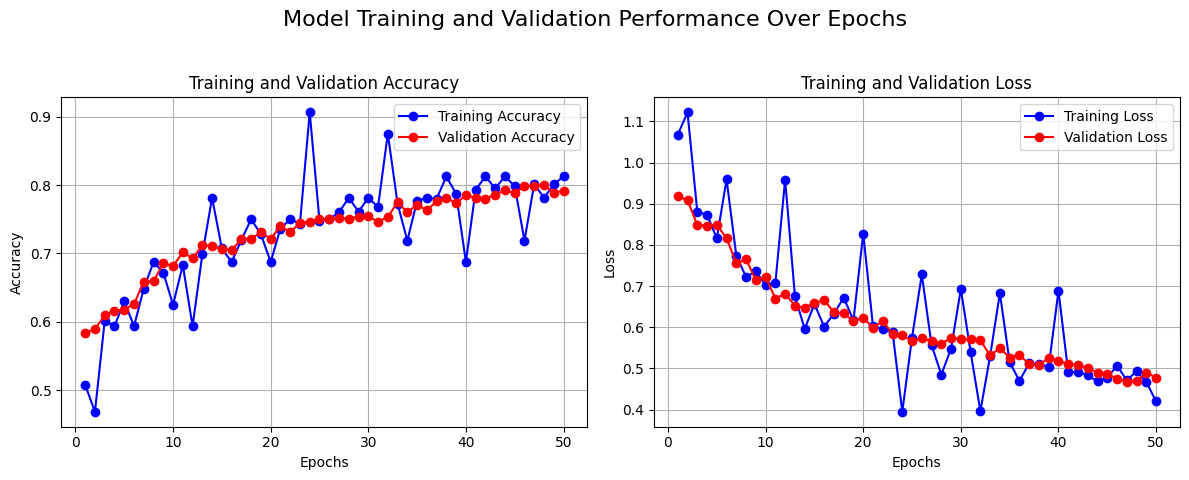

In [31]:
# Extracting the history from the trained model
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training and Validation Performance Over Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



**Classification Report:** This report provides a detailed breakdown of performance for each class, including:

* **Precision:** Of all the times it predicted a class, how often was it right?

* **Recall:** Of all the actual instances of a class, how many did it find?

* **F1-Score:** A balanced average of Precision and Recall.

In [27]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.63      0.59      0.61       896
ModerateDemented       1.00      0.22      0.36        64
     NonDemented       0.71      0.79      0.75      3200
VeryMildDemented       0.60      0.55      0.57      2240

        accuracy                           0.67      6400
       macro avg       0.74      0.53      0.57      6400
    weighted avg       0.67      0.67      0.66      6400



## Visualizations:


---


* **Confusion Matrix:** A grid that visually shows which classes the model is confusing. For example, it helps us see if it often mistakes "Mild" for "Very Mild."


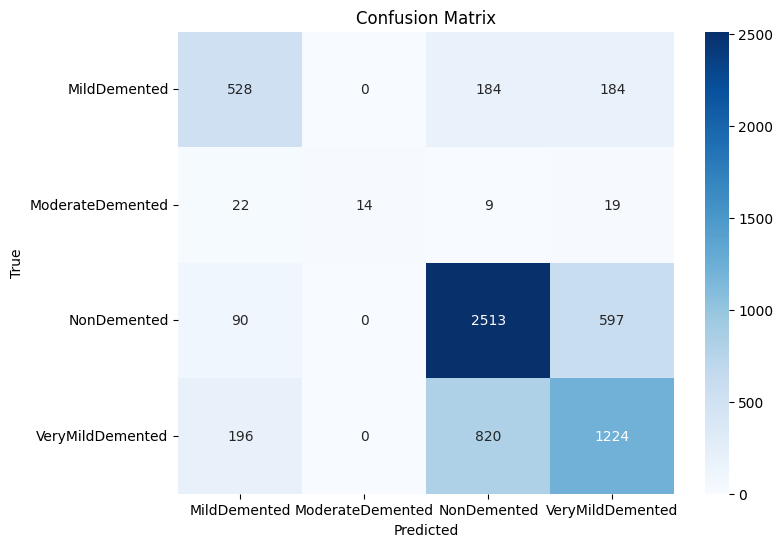

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


* **AUC-ROC Curve:** A plot that shows how well the model can distinguish between the different classes. An area under the curve (AUC) closer to 1.0 indicates a better model.

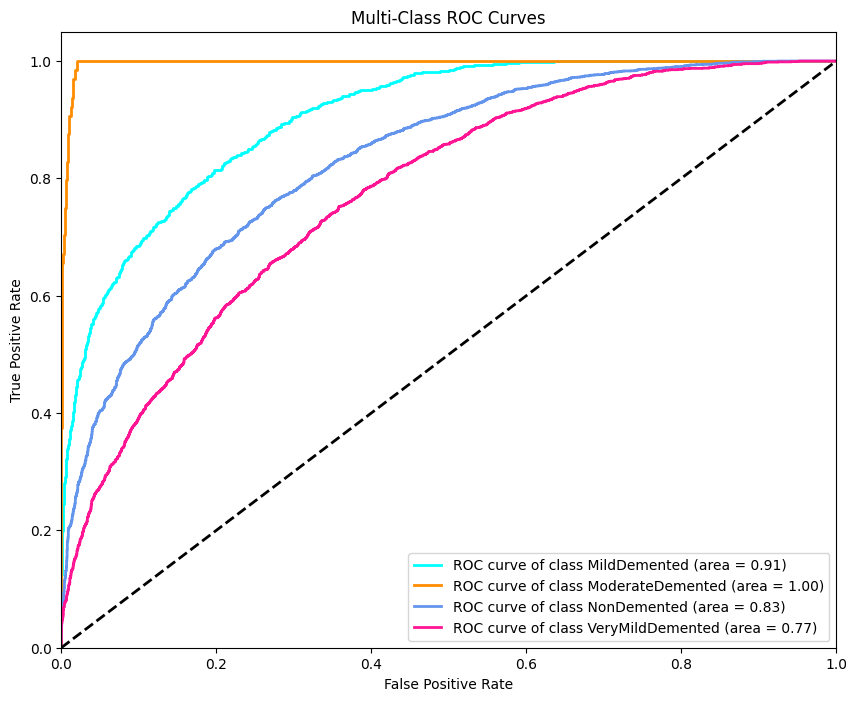

In [29]:
# AUC-ROC Curve
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.show()

**Area under the curve (AUC)	Interpretation:**
* 0.9 ≤ AUC	Excellent
* 0.8 ≤ AUC < 0.9	Good
* 0.7 ≤ AUC < 0.8	Fair
* 0.6 ≤ AUC < 0.7	Poor
* 0.5 ≤ AUC < 0.6	Fail